/tmp/ipykernel_34395/3838618202.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)
/tmp/ipykernel_34395/3838618202.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


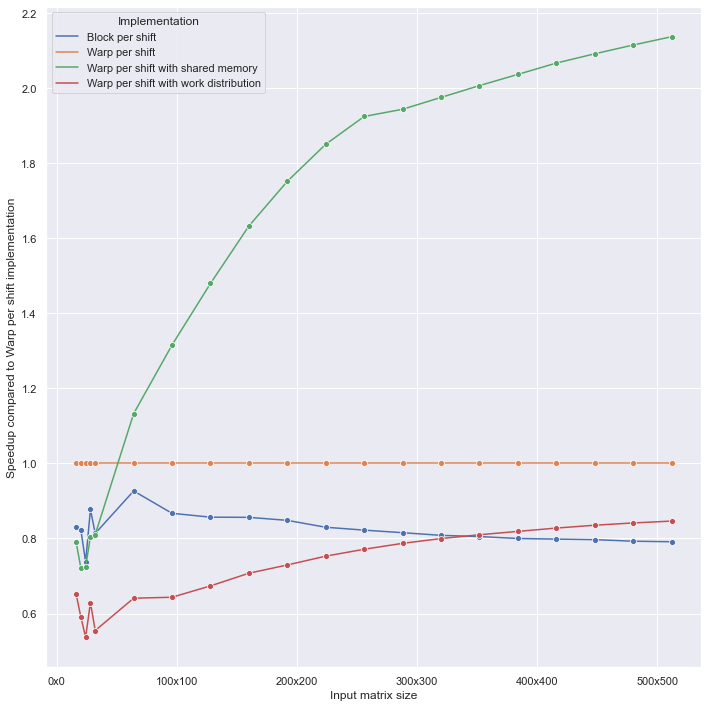

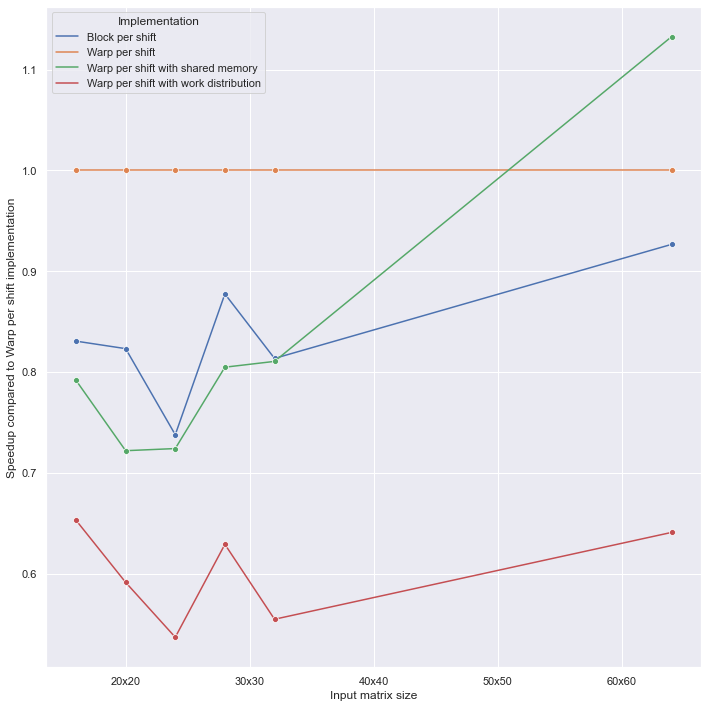

In [2]:
# ONE TO ONE
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_per_shift_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "nai_warp_per_shift"
comparison_base_args = ""
algs_and_args = {
    "nai_warp_per_shift": {
        "": "Warp per shift",
    },
    "nai_warp_per_shift_work_distribution": {
        "": "Warp per shift with work distribution",

    },
    "nai_warp_per_shift_shared_mem": {
        "": "Warp per shift with shared memory"
    },
    "nai_block_per_shift": {
        "": "Block per shift"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


def filter_data(row) -> bool:
    return row["Name"] in algs_and_args and row["Args"] in algs_and_args[row["Name"]]


data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]


def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]][
        "Kernel time"].item()
    return min_time / row["Kernel time"]


def map_name(row):
    return algs_and_args[row["Name"]][row["Args"]]


results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
#fig.savefig("warp_shuffle_against_basic.svg", format="svg")

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

results = results[results["Input matrix rows"] <= 64]

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(
    f"Speedup compared to {algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()